# **Investigating Dimensionality Reduction**

In [1]:
from astropy.table import Table
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture


## **Apogee** - 7 Gaussian Component Assignment

In [2]:
# Step 1: Load the FITS file
tbl = Table.read('XD_Results/Apogee_postGMM/apogee_GMM_scaled_Gauss7_results.fits', format='fits')

# Step 2: Extract features of interest
apogee_data_keys = ['fe_h', 'alpha_m', 'E_50', 'ce_fe', 'al_fe', 'mg_mn']
X = tbl[apogee_data_keys].to_pandas().values  # convert to NumPy array

# Step 3: Standardise the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## UMAP

/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/si

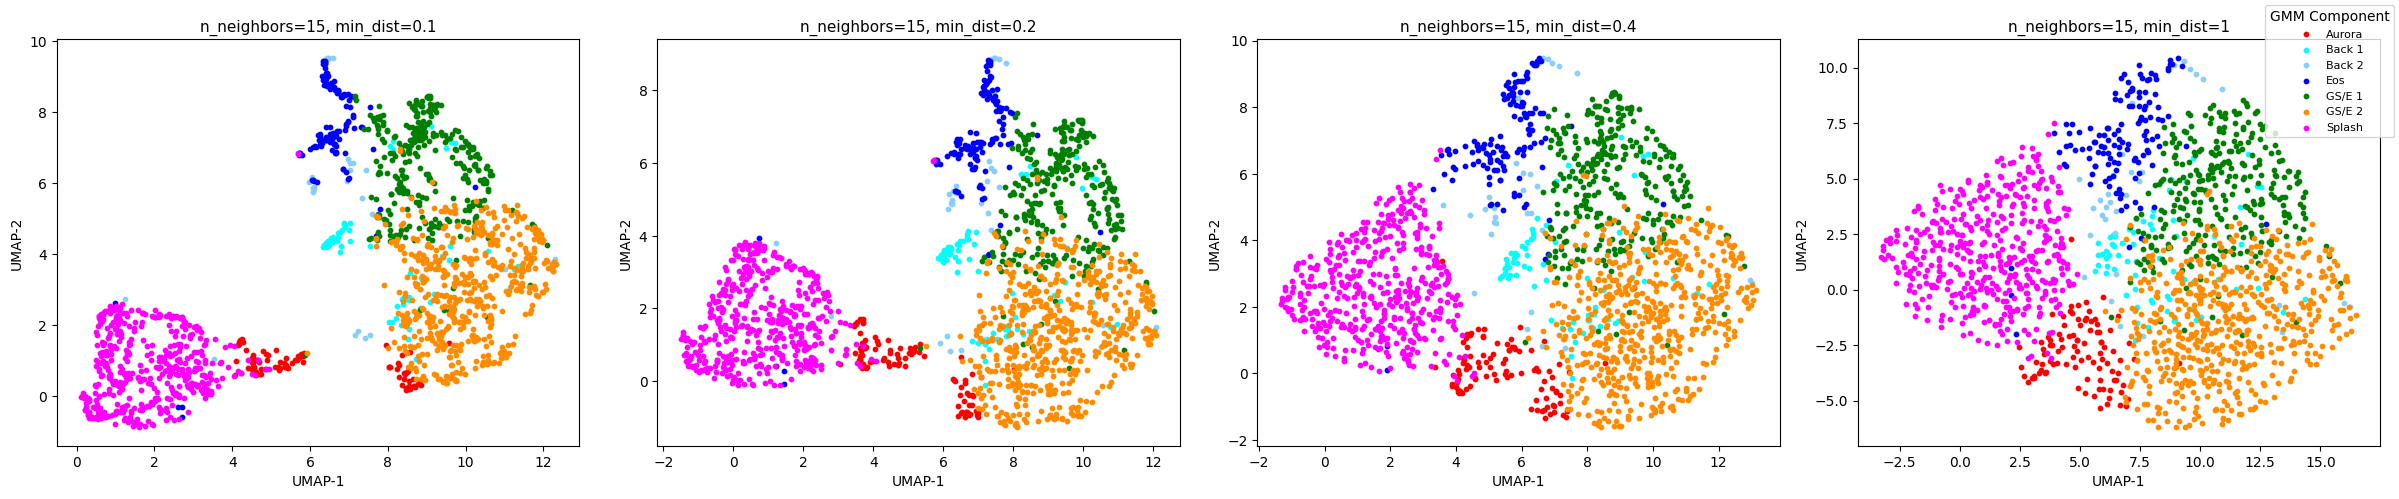

In [70]:
# --- Define multiple UMAP configurations to try ---
n_neighbors_list = [15, 15, 15, 15]
min_dist_list = [0.1, 0.2, 0.4, 1]

assert len(n_neighbors_list) == len(min_dist_list), "Lists must be the same length."

# --- Load labels and prepare names/colors ---
labels = tbl['max_gauss']
labels_name = {
    1: "GS/E 1",
    6: "GS/E 2",
    3: "Splash",
    7: "Aurora",
    2: "Eos",
    5: "Back 1",
    4: "Back 2"
}
labels_color_map = {
    "GS/E 1": "green",
    "GS/E 2": "darkorange",
    "Splash": "magenta",
    "Aurora": "red",
    "Eos": "blue",
    "Back 1": "cyan",
    "Back 2": "lightskyblue"
}

named_labels = np.array([labels_name[int(i)] for i in labels])
unique_names = sorted(set(named_labels))

# --- Create subplots ---
fig, axes = plt.subplots(1, len(n_neighbors_list), figsize=(6 * len(n_neighbors_list), 5))

# Ensure axes is iterable even if there's only one plot
if len(n_neighbors_list) == 1:
    axes = [axes]

# --- Loop through configurations and plot ---
for idx, (n_n, m_d) in enumerate(zip(n_neighbors_list, min_dist_list)):
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=n_n,
        min_dist=m_d,
        metric='euclidean',
        random_state=42
    )
    X_umap = reducer.fit_transform(X_scaled)

    ax = axes[idx]
    for name in unique_names:
        mask = named_labels == name
        ax.scatter(
            X_umap[mask, 0],
            X_umap[mask, 1],
            label=name,
            color=labels_color_map[name],
            s=10
        )

    ax.set_title(f"n_neighbors={n_n}, min_dist={m_d}", fontsize=11)
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")

# Add a legend only once, outside the plots
handles, labels_ = axes[0].get_legend_handles_labels()
fig.legend(handles, labels_, title='GMM Component', loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

## Trying to recreate clusters in this space:
- Not particulaur promising results

/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/si

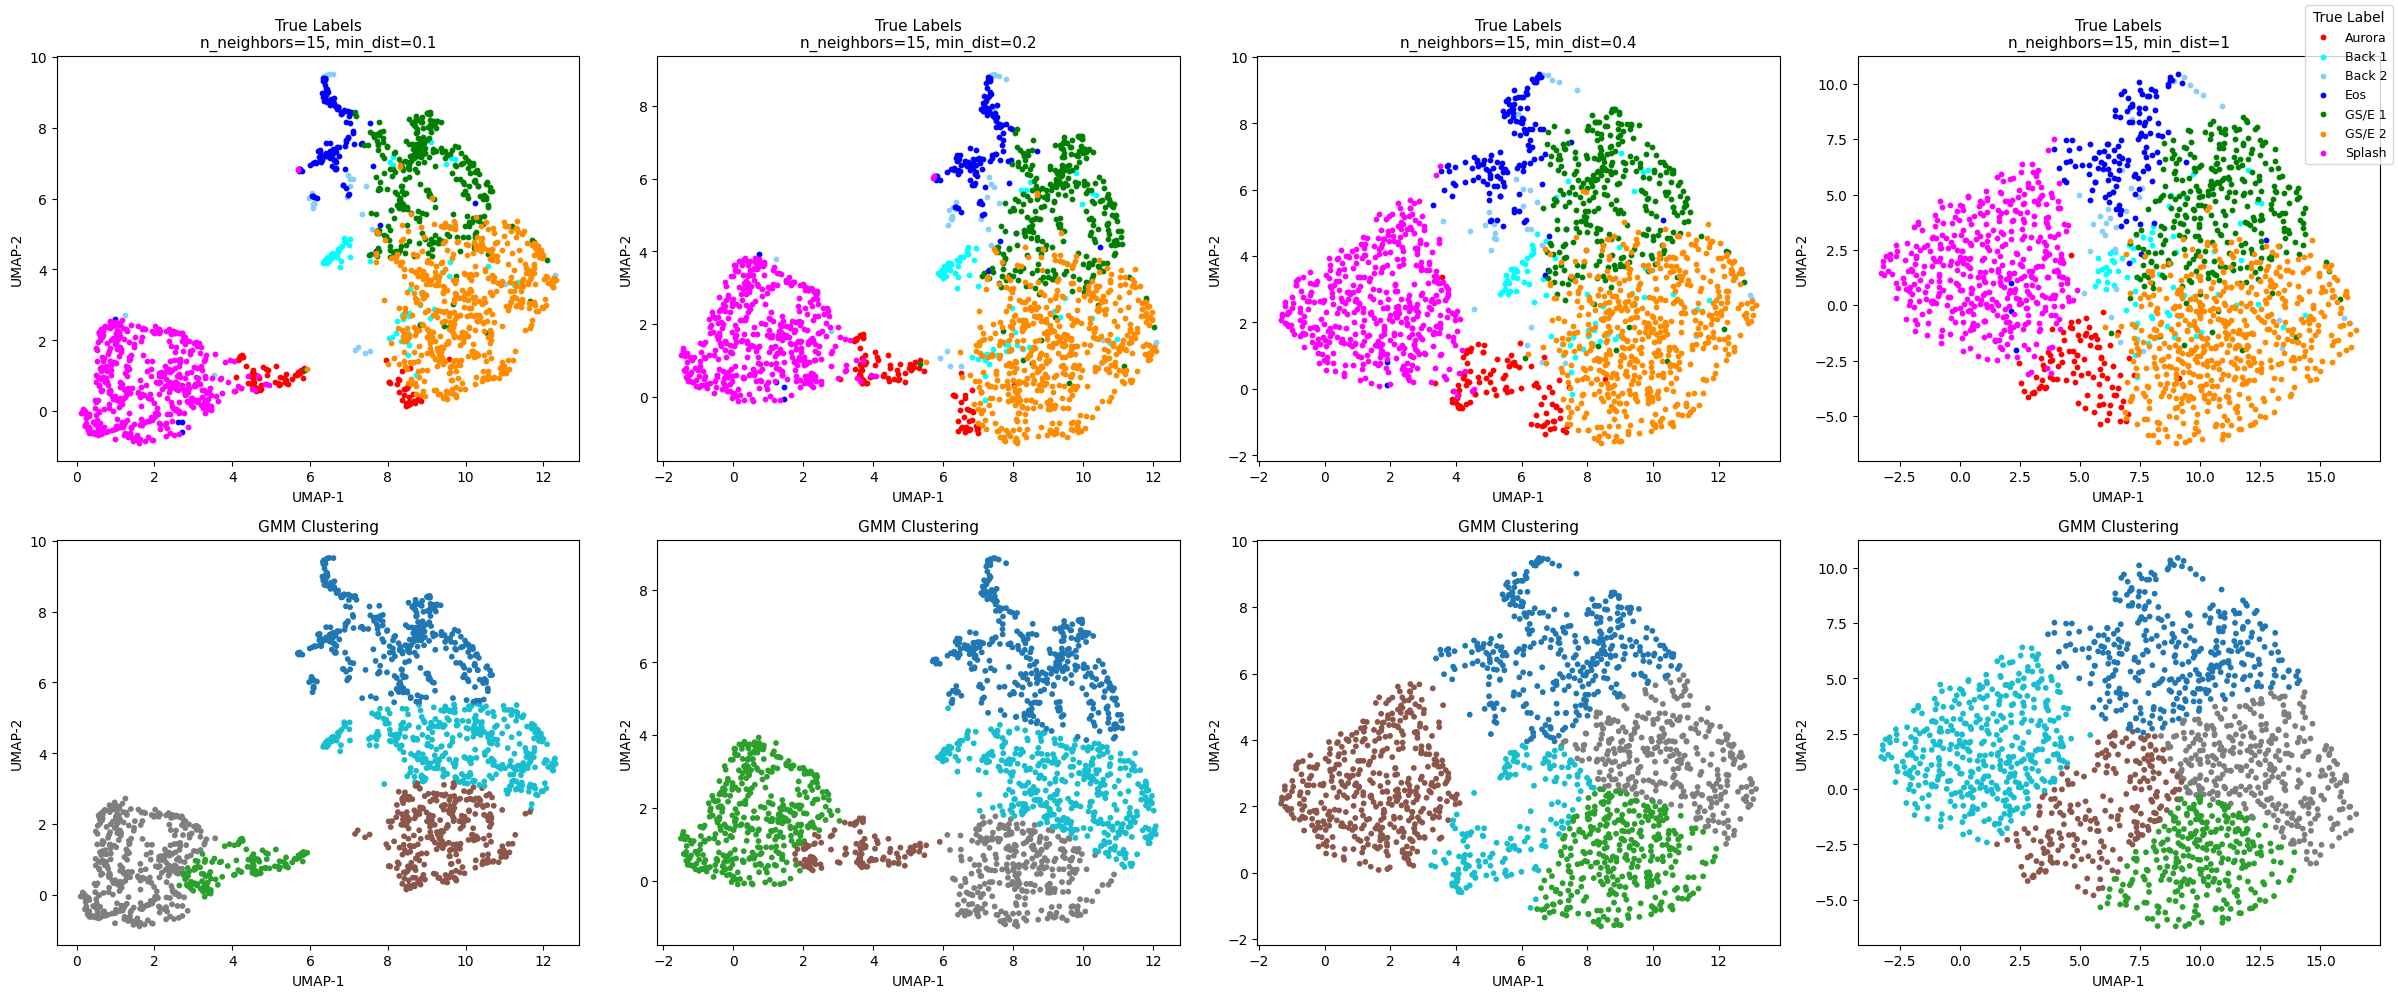

In [71]:
# --- Define multiple UMAP configurations to try ---
n_neighbors_list = [15, 15, 15, 15]
min_dist_list = [0.1, 0.2, 0.4, 1]
n_components_gmm = 5 # Number of GMM clusters to find

assert len(n_neighbors_list) == len(min_dist_list), "Lists must be the same length."

# --- Load labels and prepare names/colors ---
labels = tbl['max_gauss']
labels_name = {
    1: "GS/E 1",
    6: "GS/E 2",
    3: "Splash",
    7: "Aurora",
    2: "Eos",
    5: "Back 1",
    4: "Back 2"
}
labels_color_map = {
    "GS/E 1": "green",
    "GS/E 2": "darkorange",
    "Splash": "magenta",
    "Aurora": "red",
    "Eos": "blue",
    "Back 1": "cyan",
    "Back 2": "lightskyblue"
}

named_labels = np.array([labels_name[int(i)] for i in labels])
unique_names = sorted(set(named_labels))

# --- Create subplot grid: 2 rows (top: true labels, bottom: GMM), 1 col per config ---
fig, axes = plt.subplots(2, len(n_neighbors_list), figsize=(6 * len(n_neighbors_list), 10))

# --- Loop through configs ---
for idx, (n_n, m_d) in enumerate(zip(n_neighbors_list, min_dist_list)):
    # --- UMAP reduction ---
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=n_n,
        min_dist=m_d,
        metric='euclidean',
        random_state=42
    )
    X_umap = reducer.fit_transform(X_scaled)

    # --- TOP PLOT: UMAP by true GMM label ---
    ax_top = axes[0, idx]
    for name in unique_names:
        mask = named_labels == name
        ax_top.scatter(
            X_umap[mask, 0],
            X_umap[mask, 1],
            label=name,
            color=labels_color_map[name],
            s=10
        )
    ax_top.set_title(f"True Labels\nn_neighbors={n_n}, min_dist={m_d}", fontsize=11)
    ax_top.set_xlabel("UMAP-1")
    ax_top.set_ylabel("UMAP-2")

    # --- BOTTOM PLOT: GMM clustering on UMAP output ---
    gmm = GaussianMixture(n_components=n_components_gmm, covariance_type='full', random_state=9)
    gmm_labels = gmm.fit_predict(X_umap)

    ax_bot = axes[1, idx]
    scatter = ax_bot.scatter(X_umap[:, 0], X_umap[:, 1], c=gmm_labels, cmap='tab10', s=10)
    ax_bot.set_title("GMM Clustering", fontsize=11)
    ax_bot.set_xlabel("UMAP-1")
    ax_bot.set_ylabel("UMAP-2")

# --- Legend for the top row only (true labels) ---
handles, labels_ = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels_, title='True Label', loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

## TSNE
- Simply shown for visulisation purposes

/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


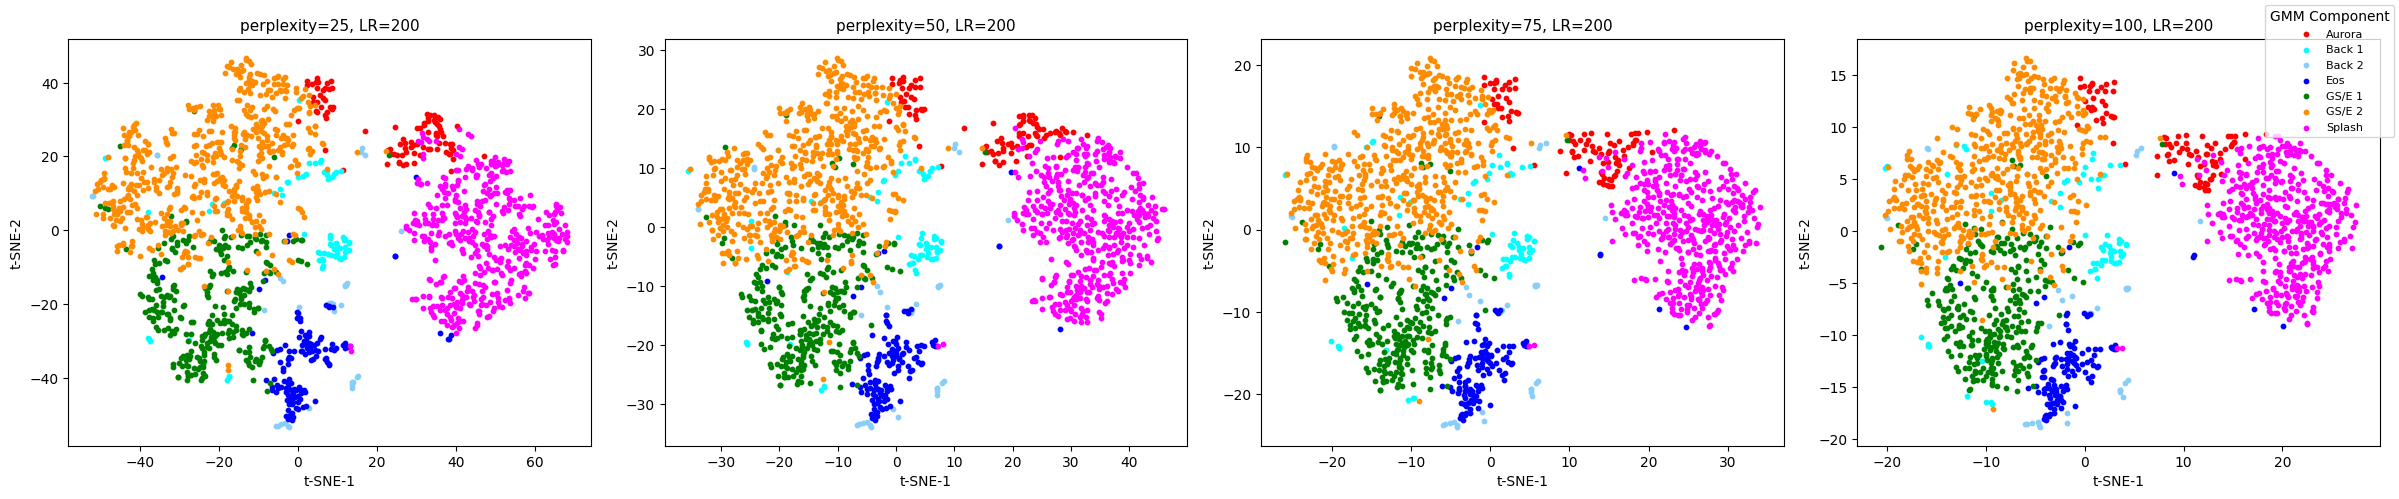

In [24]:
# --- Define multiple t-SNE configurations to try ---
perplexities = [25, 50, 75, 100]
learning_rates = [200, 200, 200, 200]

assert len(perplexities) == len(learning_rates), "Lists must be the same length."

# --- Load labels and prepare names/colors ---
labels = tbl['max_gauss']
labels_name = {
    1: "GS/E 1",
    6: "GS/E 2",
    3: "Splash",
    7: "Aurora",
    2: "Eos",
    5: "Back 1",
    4: "Back 2"
}
labels_color_map = {
    "GS/E 1": "green",
    "GS/E 2": "darkorange",
    "Splash": "magenta",
    "Aurora": "red",
    "Eos": "blue",
    "Back 1": "cyan",
    "Back 2": "lightskyblue"
}
named_labels = np.array([labels_name[int(i)] for i in labels])
unique_names = sorted(set(named_labels))

# --- Create subplots ---
fig, axes = plt.subplots(1, len(perplexities), figsize=(6 * len(perplexities), 5))

# Ensure axes is iterable even if there's only one plot
if len(perplexities) == 1:
    axes = [axes]

# --- Loop through configurations and plot ---
for idx, (perp, lr) in enumerate(zip(perplexities, learning_rates)):
    tsne = TSNE(
        n_components=2,
        perplexity=perp,
        learning_rate=lr,
        random_state=42,
        init='pca',
        n_iter=1000
    )
    X_tsne = tsne.fit_transform(X_scaled)

    ax = axes[idx]
    for name in unique_names:
        mask = named_labels == name
        ax.scatter(
            X_tsne[mask, 0],
            X_tsne[mask, 1],
            label=name,
            color=labels_color_map[name],
            s=10
        )

    ax.set_title(f"perplexity={perp}, LR={lr}", fontsize=11)
    ax.set_xlabel("t-SNE-1")
    ax.set_ylabel("t-SNE-2")

# Add a single legend outside the subplots
handles, labels_ = axes[0].get_legend_handles_labels()
fig.legend(handles, labels_, title='GMM Component', loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

## Galah - 5 Gaussian Component Assignment

In [72]:
# Step 1: Load the FITS file
tbl = Table.read('XD_Results/Galah_postGMM/Galah_GMM_scaled_Gauss5_results.fits', format='fits')

# Step 2: Extract features of interest
galah_data_keys = ['fe_h', 'alpha_fe', 'Na_fe', 'Al_fe', 'Mn_fe', 'Y_fe', 'Ba_fe', 'Eu_fe', 'Mg_Cu', 'Mg_Mn', 'Ba_Eu', 'Energy']
X = tbl[galah_data_keys].to_pandas().values  # convert to NumPy array

# Step 3: Standardise the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/si

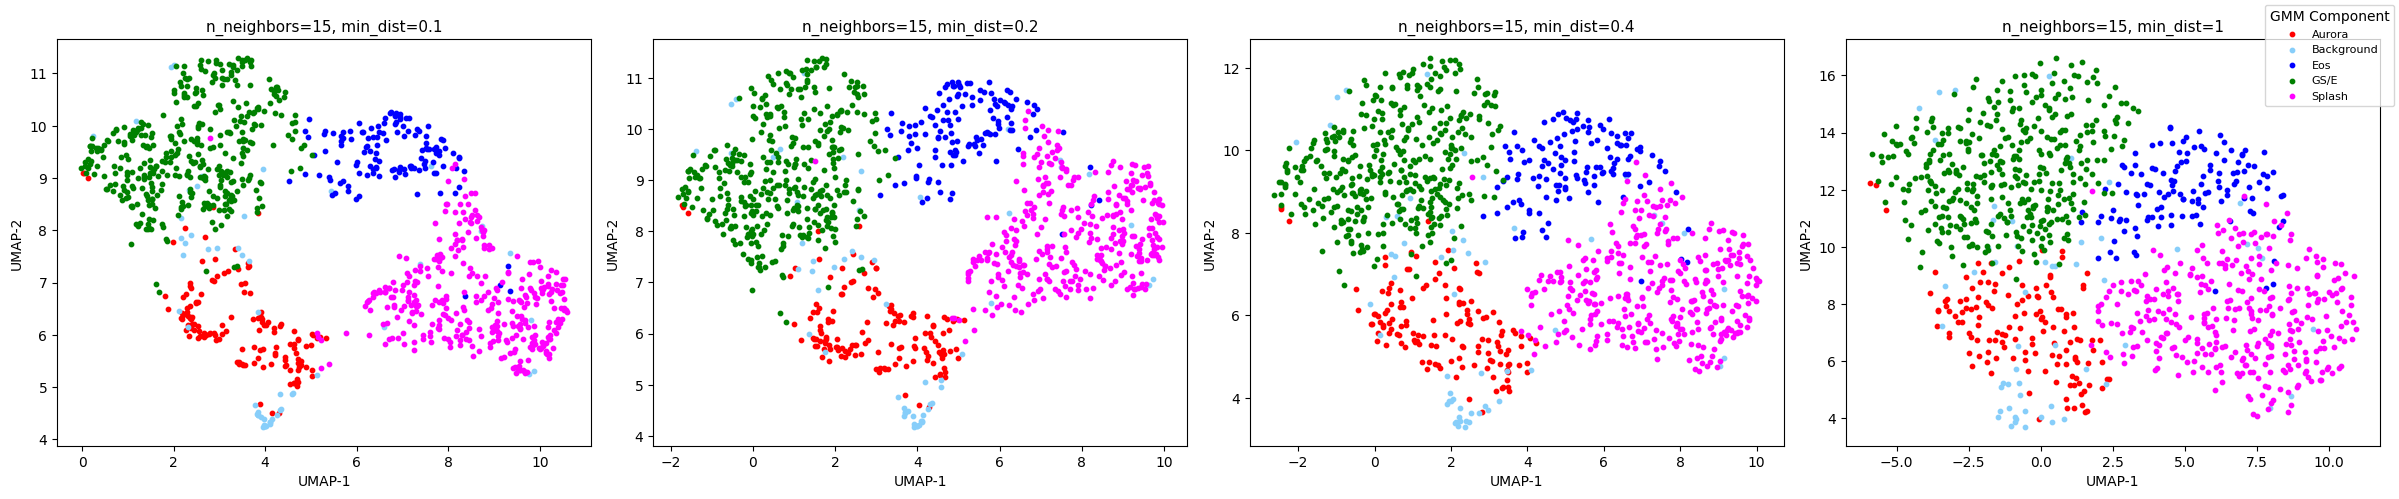

In [50]:
# --- Define multiple UMAP configurations to try ---
n_neighbors_list = [15, 15, 15, 15]
min_dist_list = [0.1, 0.2, 0.4, 1]

assert len(n_neighbors_list) == len(min_dist_list), "Lists must be the same length."

# --- Load labels and prepare names/colors ---
labels = tbl['max_gauss']
labels_name = {
    4: "GS/E",
    2: "Splash",
    1: "Aurora",
    5: "Eos",
    3: "Background",
}
labels_color_map = {
    "GS/E": "green",
    "Splash": "magenta",
    "Aurora": "red",
    "Eos": "blue",
    "Background": "lightskyblue"
}

named_labels = np.array([labels_name[int(i)] for i in labels])
unique_names = sorted(set(named_labels))

# --- Create subplots ---
fig, axes = plt.subplots(1, len(n_neighbors_list), figsize=(6 * len(n_neighbors_list), 5))

# Ensure axes is iterable even if there's only one plot
if len(n_neighbors_list) == 1:
    axes = [axes]

# --- Loop through configurations and plot ---
for idx, (n_n, m_d) in enumerate(zip(n_neighbors_list, min_dist_list)):
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=n_n,
        min_dist=m_d,
        metric='euclidean',
        random_state=42
    )
    X_umap = reducer.fit_transform(X_scaled)

    ax = axes[idx]
    for name in unique_names:
        mask = named_labels == name
        ax.scatter(
            X_umap[mask, 0],
            X_umap[mask, 1],
            label=name,
            color=labels_color_map[name],
            s=10
        )

    ax.set_title(f"n_neighbors={n_n}, min_dist={m_d}", fontsize=11)
    ax.set_xlabel("UMAP-1")
    ax.set_ylabel("UMAP-2")

# Add a legend only once, outside the plots
handles, labels_ = axes[0].get_legend_handles_labels()
fig.legend(handles, labels_, title='GMM Component', loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

## Recovering the results using GMM on lower dimensional space 
- Overwhelmingly positive results at achieving all 4 dimensions that were originally selected from GMM

/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/si

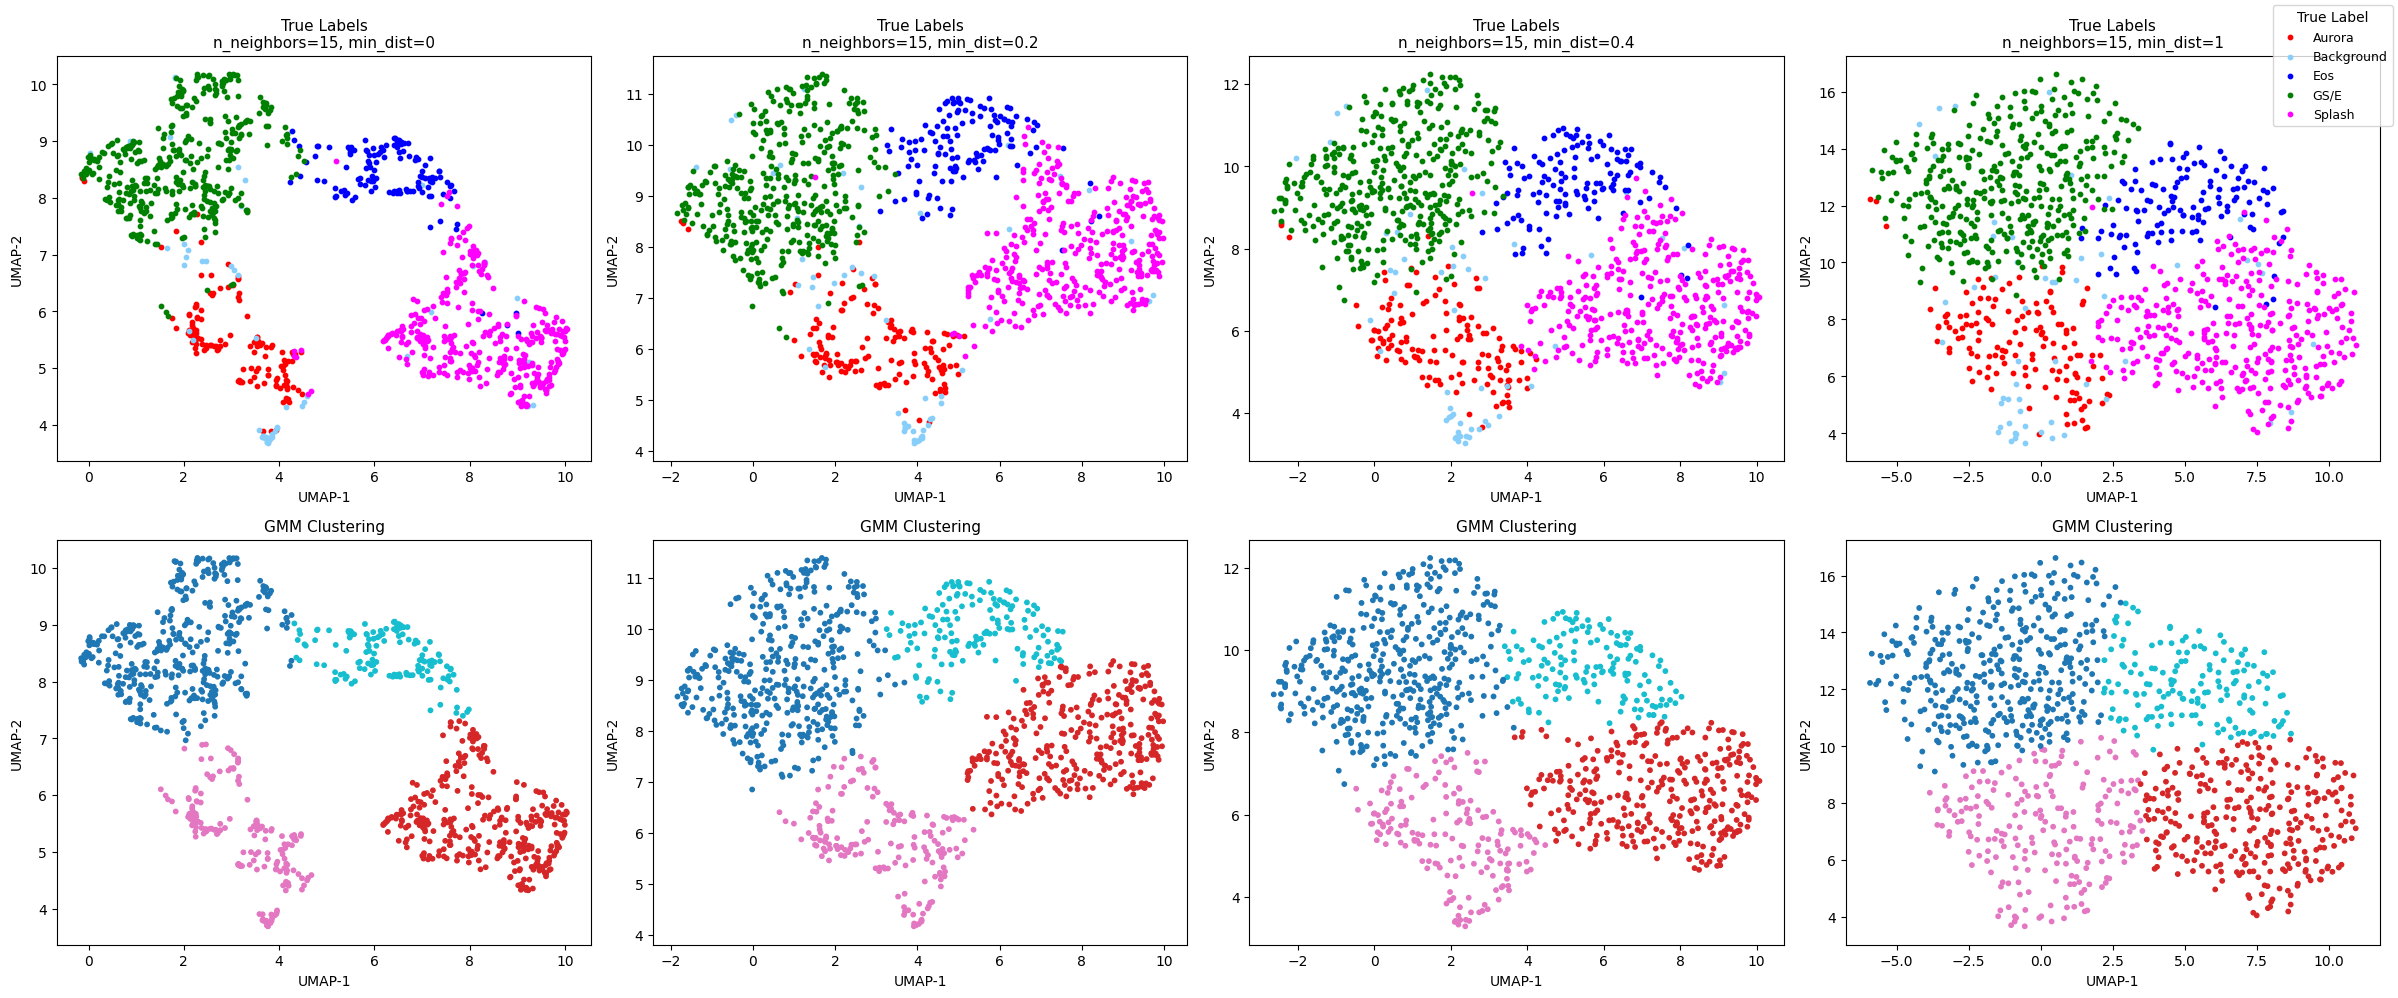

In [79]:
# --- Define UMAP configs ---
n_neighbors_list = [15, 15, 15, 15]
min_dist_list = [0, 0.2, 0.4, 1]
n_components_gmm = 4 # Number of GMM clusters to find

assert len(n_neighbors_list) == len(min_dist_list), "Lists must match."

# --- Load and prepare labels ---
labels = tbl['max_gauss']
labels_name = {
    4: "GS/E",
    2: "Splash",
    1: "Aurora",
    5: "Eos",
    3: "Background",
}
labels_color_map = {
    "GS/E": "green",
    "Splash": "magenta",
    "Aurora": "red",
    "Eos": "blue",
    "Background": "lightskyblue"
}

named_labels = np.array([labels_name[int(i)] for i in labels])
unique_names = sorted(set(named_labels))

# --- Create subplot grid: 2 rows (top: true labels, bottom: GMM), 1 col per config ---
fig, axes = plt.subplots(2, len(n_neighbors_list), figsize=(6 * len(n_neighbors_list), 10))

# --- Loop through configs ---
for idx, (n_n, m_d) in enumerate(zip(n_neighbors_list, min_dist_list)):
    # --- UMAP reduction ---
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=n_n,
        min_dist=m_d,
        metric='euclidean',
        random_state=42
    )
    X_umap = reducer.fit_transform(X_scaled)

    # --- TOP PLOT: UMAP by true GMM label ---
    ax_top = axes[0, idx]
    for name in unique_names:
        mask = named_labels == name
        ax_top.scatter(
            X_umap[mask, 0],
            X_umap[mask, 1],
            label=name,
            color=labels_color_map[name],
            s=10
        )
    ax_top.set_title(f"True Labels\nn_neighbors={n_n}, min_dist={m_d}", fontsize=11)
    ax_top.set_xlabel("UMAP-1")
    ax_top.set_ylabel("UMAP-2")

    # --- BOTTOM PLOT: GMM clustering on UMAP output ---
    gmm = GaussianMixture(n_components=n_components_gmm, covariance_type='full', random_state=90)
    gmm_labels = gmm.fit_predict(X_umap)

    ax_bot = axes[1, idx]
    scatter = ax_bot.scatter(X_umap[:, 0], X_umap[:, 1], c=gmm_labels, cmap='tab10', s=10)
    ax_bot.set_title("GMM Clustering", fontsize=11)
    ax_bot.set_xlabel("UMAP-1")
    ax_bot.set_ylabel("UMAP-2")

# --- Legend for the top row only (true labels) ---
handles, labels_ = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels_, title='True Label', loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()

## What about finding more components - ie 5
- In the GMM galah showed that adding further components simply added more background noise components but what about in this lower dimensional space
- We seem to split the GS/E section into two need componets similiar to as done in the apogee, could this be the plataeu and the knee
- To show this we will need to use these labels, project back to original dimension space and determine 2D projections manually.

/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/jacobtutt/Desktop/MPhil_DIS/Project/diss_venvs/diss_2/lib/python3.10/si

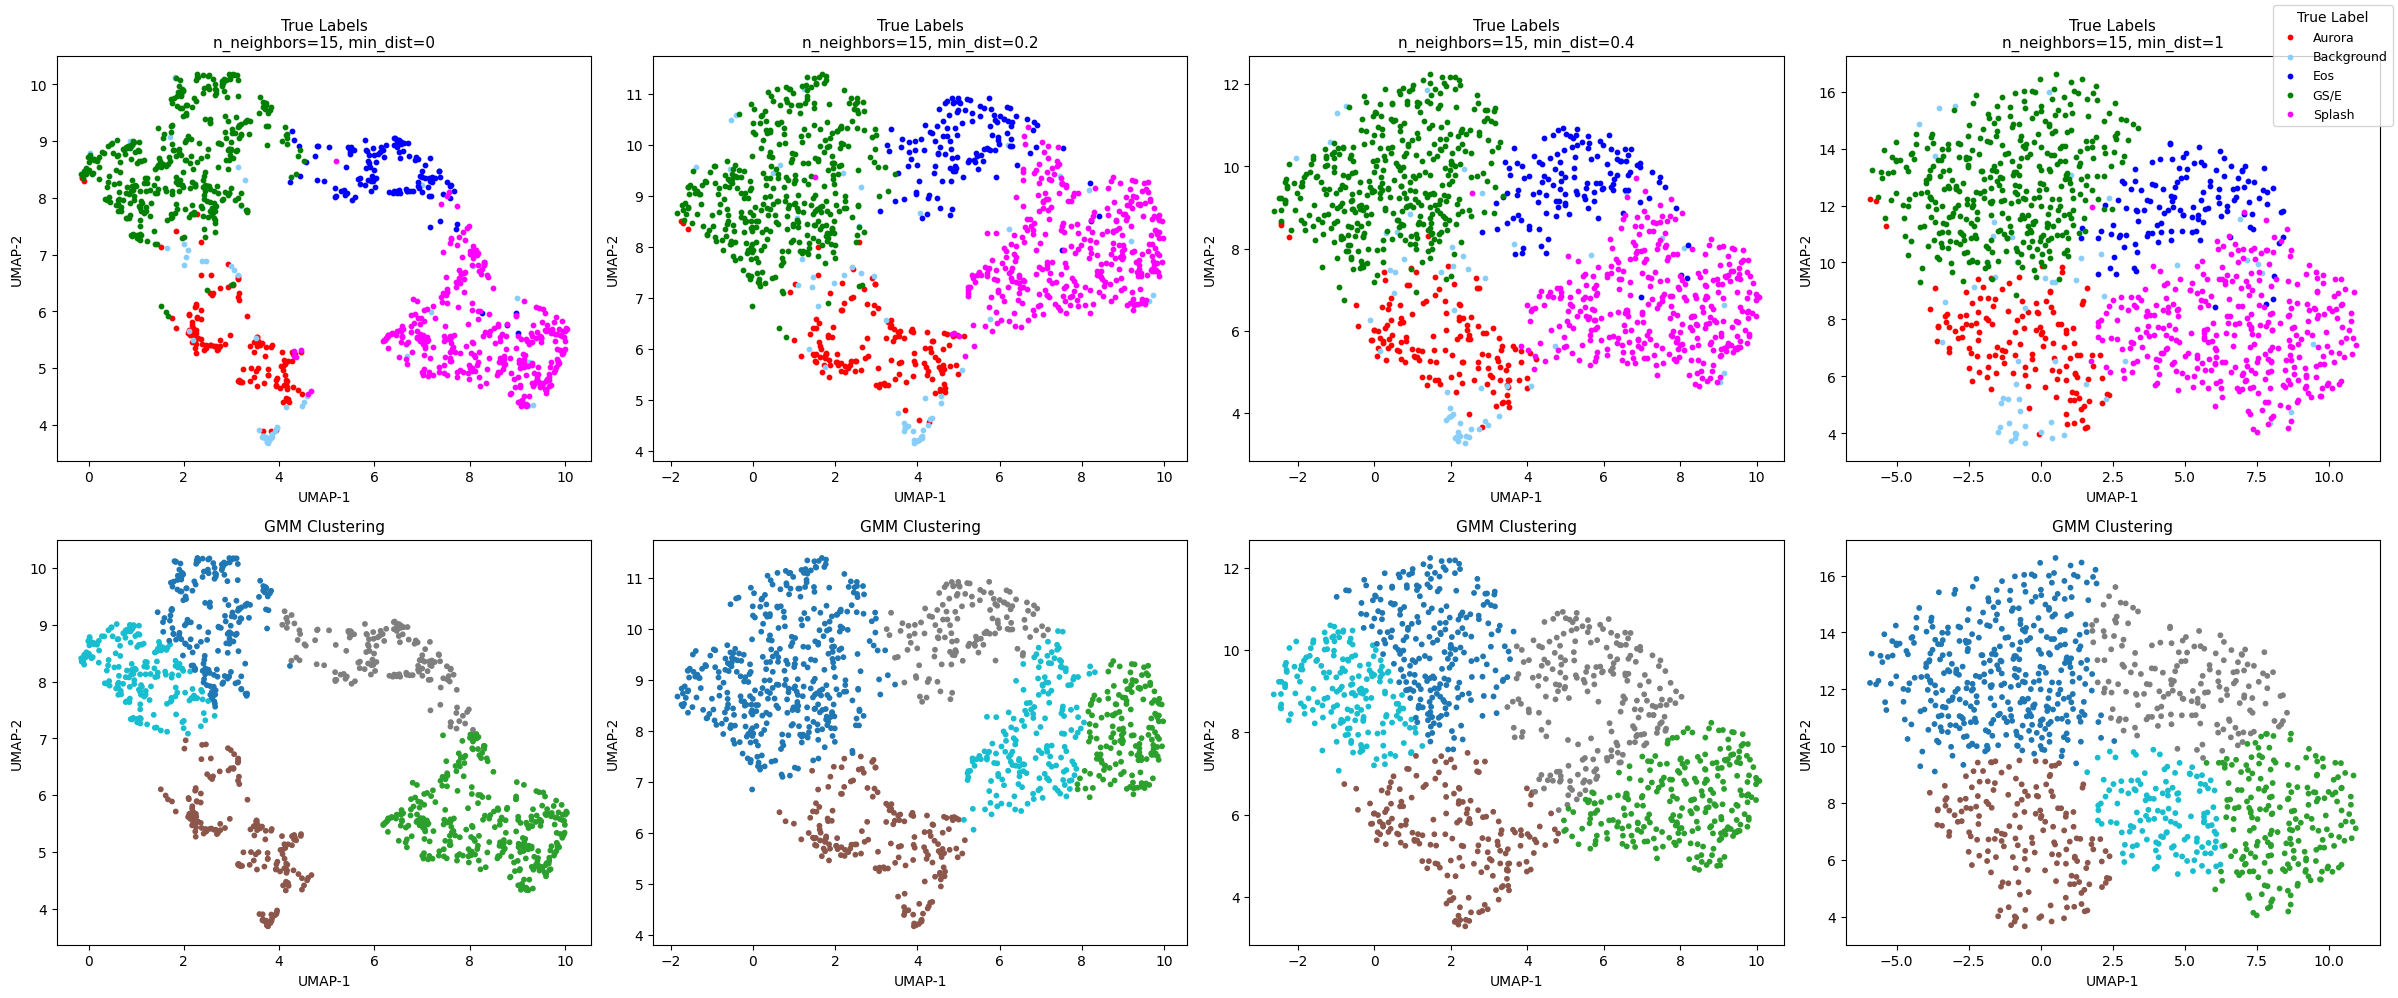

In [80]:
# --- Define UMAP configs ---
n_neighbors_list = [15, 15, 15, 15]
min_dist_list = [0, 0.2, 0.4, 1]
n_components_gmm = 5 # Number of GMM clusters to find

assert len(n_neighbors_list) == len(min_dist_list), "Lists must match."

# --- Load and prepare labels ---
labels = tbl['max_gauss']
labels_name = {
    4: "GS/E",
    2: "Splash",
    1: "Aurora",
    5: "Eos",
    3: "Background",
}
labels_color_map = {
    "GS/E": "green",
    "Splash": "magenta",
    "Aurora": "red",
    "Eos": "blue",
    "Background": "lightskyblue"
}

named_labels = np.array([labels_name[int(i)] for i in labels])
unique_names = sorted(set(named_labels))

# --- Create subplot grid: 2 rows (top: true labels, bottom: GMM), 1 col per config ---
fig, axes = plt.subplots(2, len(n_neighbors_list), figsize=(6 * len(n_neighbors_list), 10))

# --- Loop through configs ---
for idx, (n_n, m_d) in enumerate(zip(n_neighbors_list, min_dist_list)):
    # --- UMAP reduction ---
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=n_n,
        min_dist=m_d,
        metric='euclidean',
        random_state=42
    )
    X_umap = reducer.fit_transform(X_scaled)

    # --- TOP PLOT: UMAP by true GMM label ---
    ax_top = axes[0, idx]
    for name in unique_names:
        mask = named_labels == name
        ax_top.scatter(
            X_umap[mask, 0],
            X_umap[mask, 1],
            label=name,
            color=labels_color_map[name],
            s=10
        )
    ax_top.set_title(f"True Labels\nn_neighbors={n_n}, min_dist={m_d}", fontsize=11)
    ax_top.set_xlabel("UMAP-1")
    ax_top.set_ylabel("UMAP-2")

    # --- BOTTOM PLOT: GMM clustering on UMAP output ---
    gmm = GaussianMixture(n_components=n_components_gmm, covariance_type='full', random_state=90)
    gmm_labels = gmm.fit_predict(X_umap)

    ax_bot = axes[1, idx]
    scatter = ax_bot.scatter(X_umap[:, 0], X_umap[:, 1], c=gmm_labels, cmap='tab10', s=10)
    ax_bot.set_title("GMM Clustering", fontsize=11)
    ax_bot.set_xlabel("UMAP-1")
    ax_bot.set_ylabel("UMAP-2")

# --- Legend for the top row only (true labels) ---
handles, labels_ = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels_, title='True Label', loc='upper right', fontsize=9)

plt.tight_layout()
plt.show()